In [61]:
import sys
sys.path.append('/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/lcls_tools') # path to tools 
import common.data_analysis.archiver as arch # type: ignore
from datetime import datetime
from datetime import timedelta
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [62]:
from bs4 import BeautifulSoup

def get_pairs_of_dates(file_path): 
    # Open and read the local HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Create a BeautifulSoup object and specify the parser
    soup = BeautifulSoup(html_content, 'html.parser')
    dates = []
    times = []
    
    # Find all tags with class 'header_date'
    date_tags = soup.find_all(class_='header_date')
    for tag in date_tags:
        curr_date = tag.get_text(strip=True)
        dates.append(curr_date)
    
    # Find all tags with class 'header_time'
    time_tags = soup.find_all(class_='header_time')
    for tag in time_tags:
        curr_time = tag.get_text(strip=True)
        times.append(curr_time)
        
    datetimes = []
    
    for index in range(len(dates)):
        datetimes.append(f"{dates[index]} {times[index]}")
    
    date_lists = [[(datetime.strptime(datetimes[i], "%m/%d/%Y %H:%M") - timedelta(minutes=10)).strftime("%Y/%m/%d %H:%M:%S"), 
               datetime.strptime(datetimes[i], "%m/%d/%Y %H:%M").strftime("%Y/%m/%d %H:%M:%S")] for i in range(len(datetimes))]
    
    return date_lists

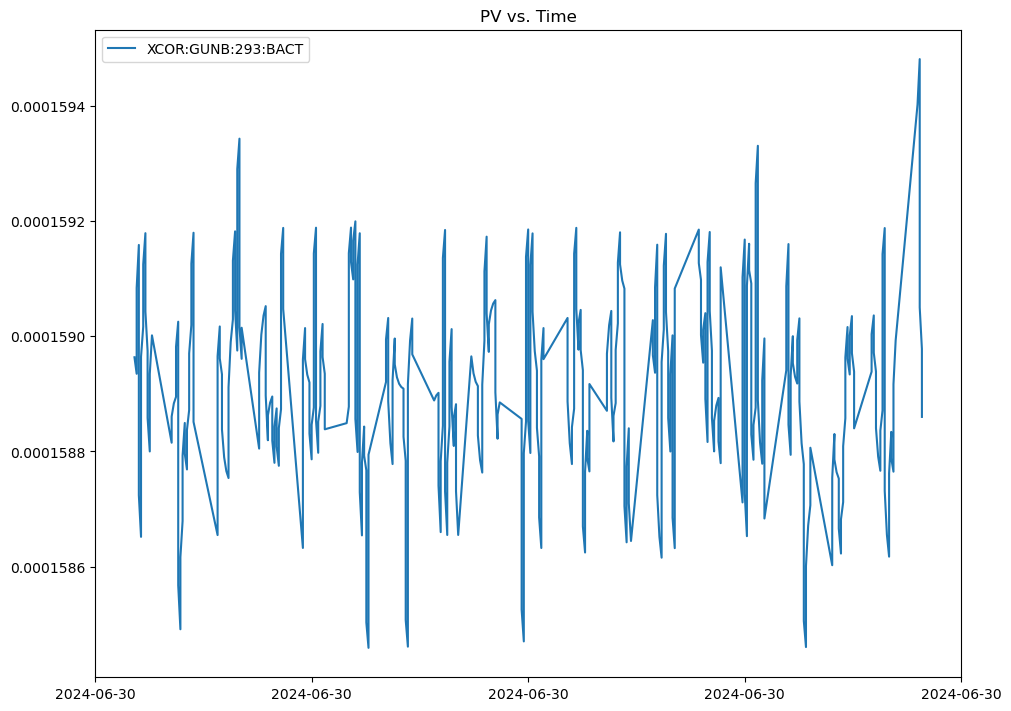

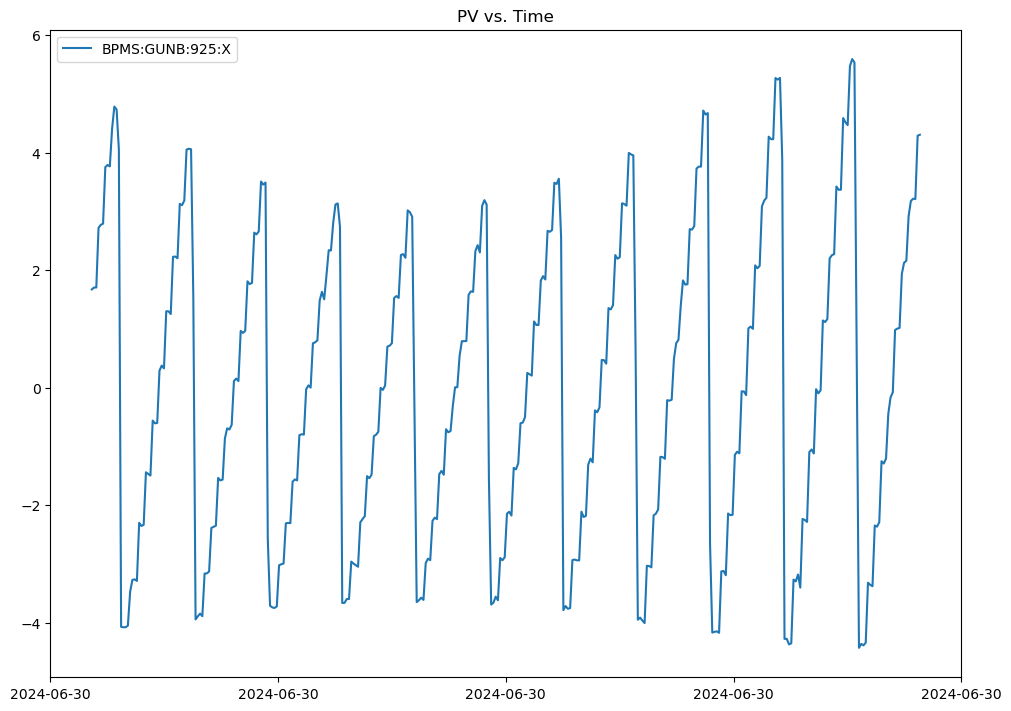

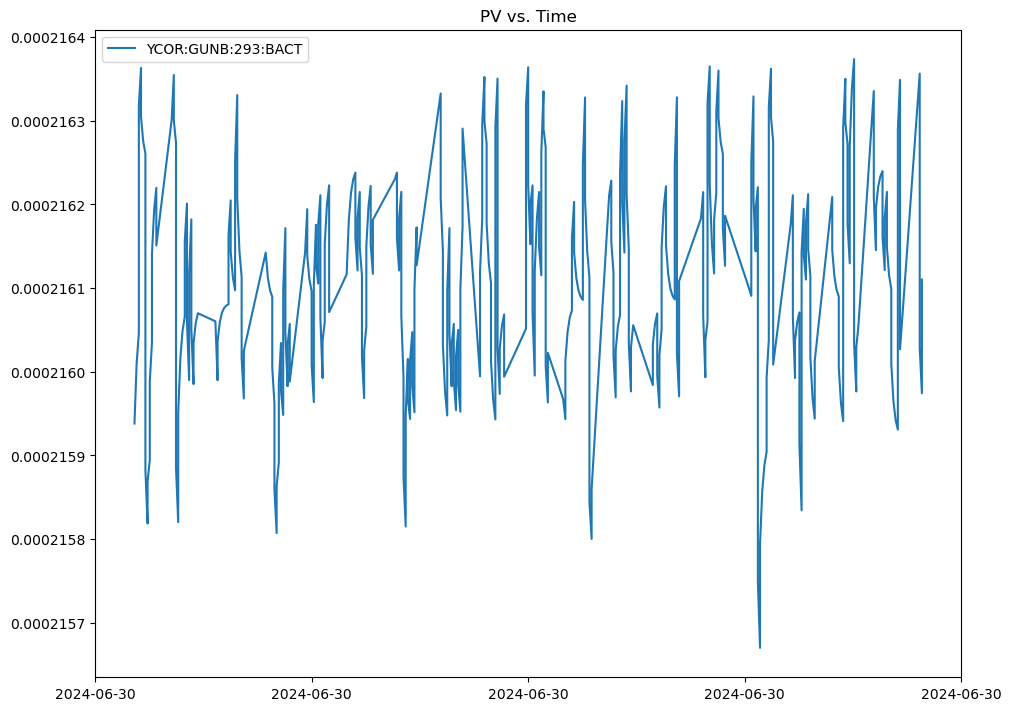

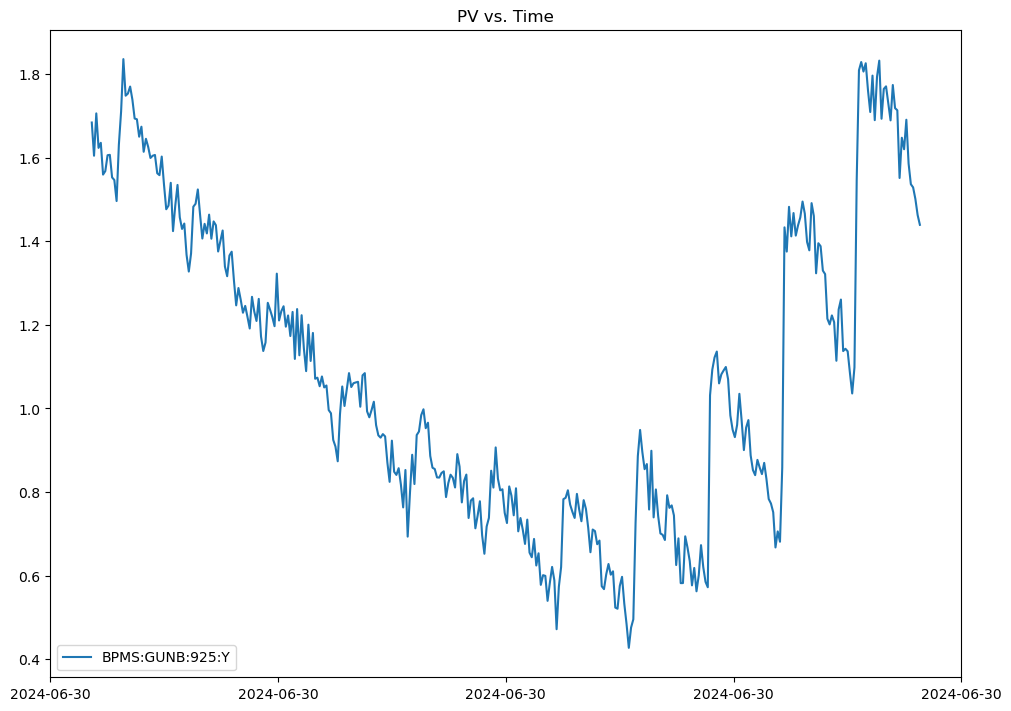

In [63]:
date = ("2024/06/30 09:50:00", "2024/06/30 09:56:00")
xcor_pv = "XCOR:GUNB:293:BACT"
bpmx_pv = "BPMS:GUNB:925:X"
ycor_pv = "YCOR:GUNB:293:BACT"
bpmy_pv = "BPMS:GUNB:925:Y"
pv_list = [xcor_pv, bpmx_pv, ycor_pv, bpmy_pv]

for x in range(4): 
    start_date = date[0]
    end_date = date[1]
    start_date_obj = datetime.strptime(start_date, "%Y/%m/%d %H:%M:%S")
    end_date_obj = datetime.strptime(end_date, "%Y/%m/%d %H:%M:%S")
    
    data = arch.get_values_over_time_range([pv_list[x]], start_date_obj, end_date_obj)
    data_dict = data[pv_list[x]]
    data_timestamps = data_dict.timestamps
    data_values = data_dict.values

    df = pd.DataFrame({"timestamps": data_timestamps, pv_list[x]: data_values})
    
    fig, ax = plt.subplots(figsize=(10, 7), layout='constrained')
    ax.plot(df["timestamps"], df[pv_list[x]], label=pv_list[x])
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_title("PV vs. Time") 
    ax.legend() 